In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import yaml

In [2]:
%run ./src/database.py
%run ./src/util.py
%run ./src/feature_engineering.py

In [3]:
YAML_FILEPATHNAME = "./config.yaml"
PRE_CRUISE_DB = 0
POST_CRUISE_DB = 1

In [4]:
# Read YAML file
yaml_data = read_yaml(YAML_FILEPATHNAME)

# Preprocessing

In [5]:
DATA_PATH = yaml_data['data_path']
TEST_SIZE = yaml_data['test_size']
RANDOM_STATE = yaml_data['random_state']
TARGET_VARIABLE = yaml_data['target_variable']

In [6]:
# Read Pre_cruise Data
ds_pre_cruise = Database(DATA_PATH)
df_pre_cruise = ds_pre_cruise.db_read(yaml_data['databases'][PRE_CRUISE_DB])

In [7]:
# Read Post_cruise Data
ds_post_cruise = Database(DATA_PATH)
df_post_cruise = ds_post_cruise.db_read(yaml_data['databases'][POST_CRUISE_DB])

In [8]:
# Merge Pre_cruise and Post_cruise data
df_cruise = merge_dataframe (df_pre_cruise, df_post_cruise)

In [9]:
df_cruise.shape

(130875, 25)

In [10]:
### There are 130875 rows and 25 columns

In [11]:
df_cruise.head(5)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,...,Onboard Service,Cleanliness,Ext_Intcode_x,Cruise Name,Ticket Type,Cruise Distance,Ext_Intcode_y,WiFi,Dining,Entertainment
index,,,,,,,,,,,,,,,,,,,,,
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,...,2.0,3.0,LB446RWOOZI,Blastoise,None,3567 KM,LB446RWOOZI,1.0,1,1.0
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,...,4.0,4.0,LB138HKBECM,Blastoise,Deluxe,672 KM,LB138HKBECM,NaN,0,1.0
2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,...,3.0,NaN,BL713UHBAAN,IAPRAS,Deluxe,1167 KM,BL713UHBAAN,NaN,0,0.0
3,Female,01/05/1970,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,...,2.0,4.0,LB243DMKCFL,Lapras,Deluxe,280 KM,LB243DMKCFL,NaN,0,1.0
4,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,...,2.0,NaN,LB218CFLOBS,Lapras,Standard,1145 Miles,LB218CFLOBS,NaN,1,NaN


In [12]:
# Split composite field to increase interpretability
split_column(df_cruise, 'Source of Traffic', ['Source', 'Traffic'], ' - ')

split_column(df_cruise, 'Cruise Distance', ['Distance', 'Dist_Metrics'], ' ')
df_cruise['Distance'] = pd.to_numeric(df_cruise['Distance'], errors='coerce').astype('float')

In [13]:
convert_object_to_datetime (df_cruise, ['Date of Birth'],['%d/%m/%Y'])
convert_object_to_datetime (df_cruise, ['Logging'],['%d/%m/%Y %H:%M'])

In [14]:
remove_missing_value(df_cruise,['Date of Birth', TARGET_VARIABLE, 'Distance','Logging'])

In [15]:
convert_datetime_to_year(df_cruise, ['Date of Birth','Logging'],['Year of Birth','Year of Logging'])

In [16]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84459 entries, 2 to 133745
Data columns (total 27 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      75904 non-null  object 
 1   Onboard Wifi Service                        72186 non-null  object 
 2   Embarkation/Disembarkation time convenient  74625 non-null  float64
 3   Ease of Online booking                      72801 non-null  float64
 4   Gate location                               73566 non-null  float64
 5   Onboard Dining Service                      73876 non-null  object 
 6   Online Check-in                             74523 non-null  float64
 7   Cabin Comfort                               71644 non-null  float64
 8   Onboard Entertainment                       74485 non-null  object 
 9   Cabin service                               75731 non-null  float64
 10  Baggage handli

In [17]:
df_cruise.head()

,Gender,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,...,Ext_Intcode_y,WiFi,Dining,Entertainment,Source,Traffic,Distance,Dist_Metrics,Year of Birth,Year of Logging
index,,,,,,,,,,,,,,,,,,,,,
2,Female,None,3.0,0.0,5.0,None,NaN,5.0,Extremely important,2.0,...,BL713UHBAAN,NaN,0,0.0,Indirect,Search Engine,1167.0,KM,1998,2023
3,Female,Very important,4.0,4.0,4.0,Somewhat important,4.0,4.0,None,NaN,...,LB243DMKCFL,NaN,0,1.0,Direct,Company Website,280.0,KM,1970,2023
4,Male,Somewhat important,4.0,2.0,NaN,Not at all important,2.0,NaN,Not at all important,3.0,...,LB218CFLOBS,NaN,1,NaN,Direct,Company Website,1145.0,Miles,1960,2023
6,Male,Somewhat important,5.0,3.0,3.0,Very important,NaN,4.0,Very important,NaN,...,BL115AWWXPU,NaN,1,NaN,Direct,Email Marketing,607.0,KM,1986,2023
10,Male,A little important,NaN,NaN,1.0,Extremely important,2.0,3.0,Extremely important,3.0,...,BL600CHOVHP,NaN,0,NaN,Direct,Email Marketing,594.0,KM,2008,2023


In [18]:
# Convert non-numeric cateogoric columns to numeric by LabelEncoder
list_non_numeric_col = ['Gender','Onboard Wifi Service','Onboard Dining Service','Onboard Entertainment','Cruise Name',
                            'Ticket Type','Source','Traffic','Dist_Metrics']
label_encoder(df_cruise,list_non_numeric_col)

In [19]:
#Remove ID columns Ext_Intcode_x and Ext_Intcode_y 
remove_col(df_cruise,['Ext_Intcode_x', 'Ext_Intcode_y'])

In [20]:
output_csv(DATA_PATH, df_cruise, "df_cruise")

In [21]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84459 entries, 2 to 133745
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      84459 non-null  int32  
 1   Onboard Wifi Service                        84459 non-null  int32  
 2   Embarkation/Disembarkation time convenient  74625 non-null  float64
 3   Ease of Online booking                      72801 non-null  float64
 4   Gate location                               73566 non-null  float64
 5   Onboard Dining Service                      84459 non-null  int32  
 6   Online Check-in                             74523 non-null  float64
 7   Cabin Comfort                               71644 non-null  float64
 8   Onboard Entertainment                       84459 non-null  int32  
 9   Cabin service                               75731 non-null  float64
 10  Baggage handli

# Feature Engineering

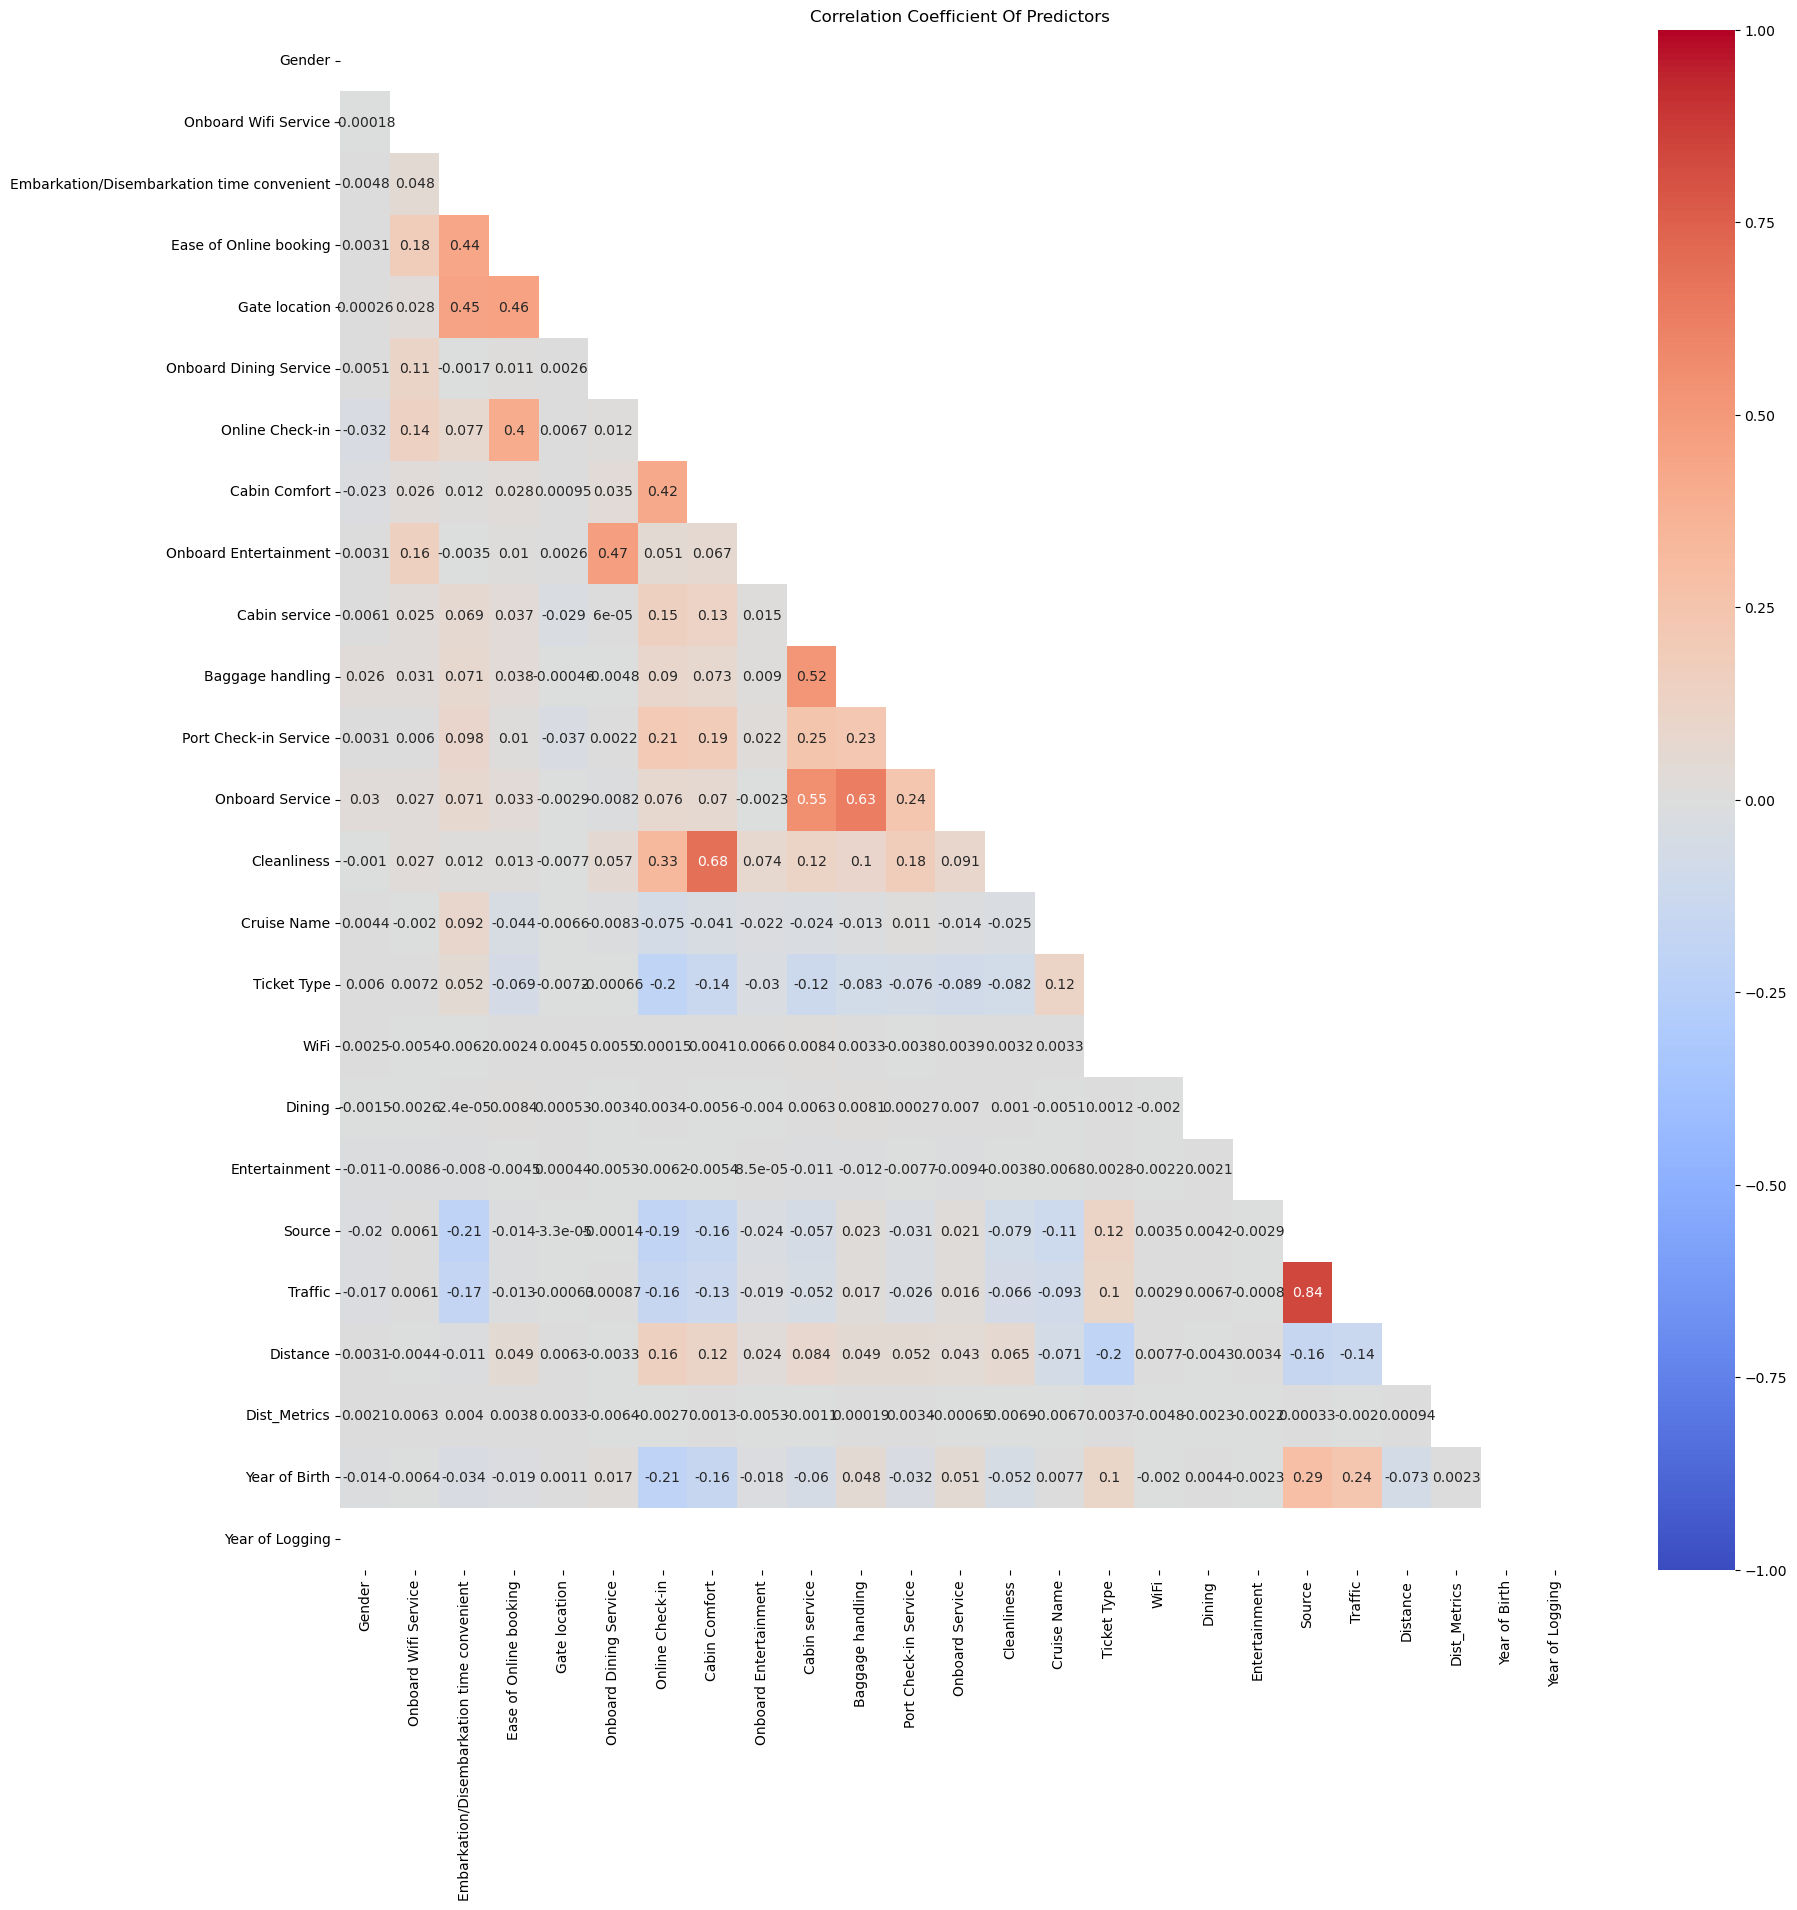

In [22]:
plot_corr_chart(df_cruise)

In [23]:
# Impute Missing Value in dataframe
impute_missing_value(df_cruise)

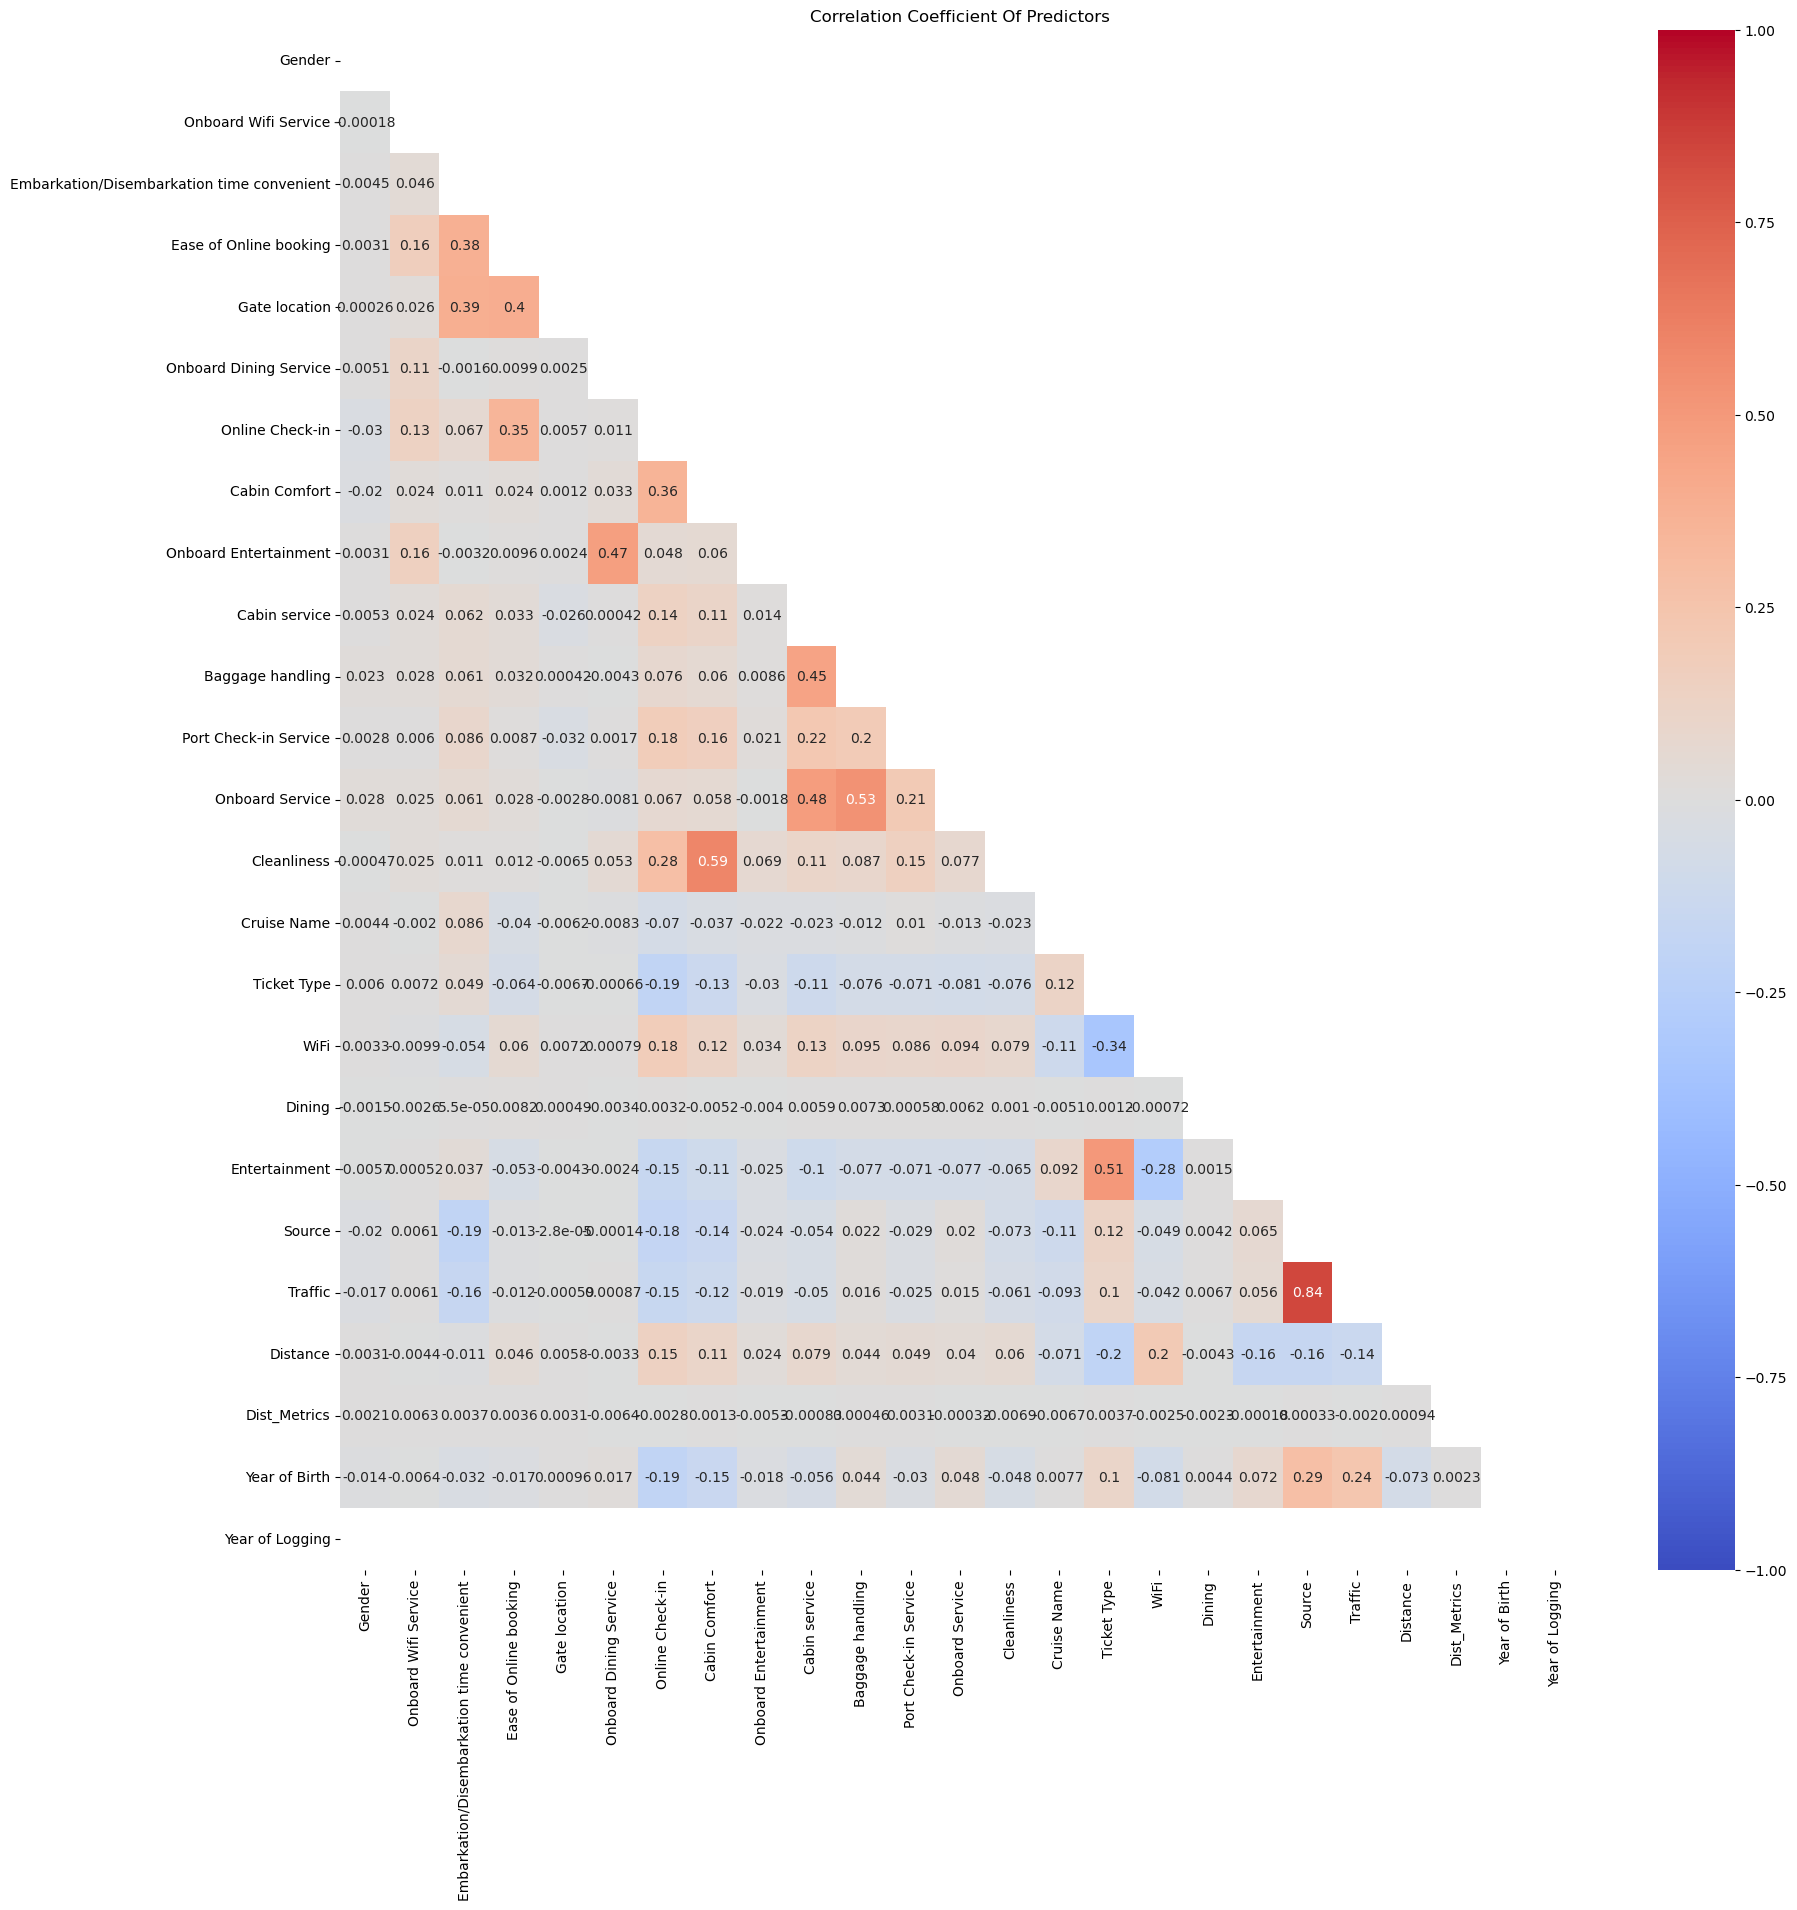

In [24]:
plot_corr_chart(df_cruise)

# Model Building

In [25]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84459 entries, 2 to 133745
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      84459 non-null  int32  
 1   Onboard Wifi Service                        84459 non-null  int32  
 2   Embarkation/Disembarkation time convenient  84459 non-null  float64
 3   Ease of Online booking                      84459 non-null  float64
 4   Gate location                               84459 non-null  float64
 5   Onboard Dining Service                      84459 non-null  int32  
 6   Online Check-in                             84459 non-null  float64
 7   Cabin Comfort                               84459 non-null  float64
 8   Onboard Entertainment                       84459 non-null  int32  
 9   Cabin service                               84459 non-null  float64
 10  Baggage handli

In [26]:
X = df_cruise.drop([TARGET_VARIABLE],axis=1)
y = df_cruise[TARGET_VARIABLE]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE , random_state=RANDOM_STATE)

In [27]:
# from imblearn.over_sampling import SMOTE


# os = SMOTE(random_state=RANDOM_STATE)
# columns = X.columns
# X_train, y_train = os.fit_resample(X_train, y_train)

In [28]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84459 entries, 2 to 133745
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      84459 non-null  int32  
 1   Onboard Wifi Service                        84459 non-null  int32  
 2   Embarkation/Disembarkation time convenient  84459 non-null  float64
 3   Ease of Online booking                      84459 non-null  float64
 4   Gate location                               84459 non-null  float64
 5   Onboard Dining Service                      84459 non-null  int32  
 6   Online Check-in                             84459 non-null  float64
 7   Cabin Comfort                               84459 non-null  float64
 8   Onboard Entertainment                       84459 non-null  int32  
 9   Cabin service                               84459 non-null  float64
 10  Baggage handli

In [29]:
log_regression = LogisticRegression(random_state=RANDOM_STATE, max_iter=5000)
log_regression.fit(X_train, y_train)
y_train_pred_log = log_regression.predict(X_train)
y_test_pred_log = log_regression.predict(X_test)

In [30]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_train_pred_rf = random_forest.predict(X_train)
y_test_pred_rf = random_forest.predict(X_test)

# Model Evaluation

In [33]:
from sklearn import metrics
print("Classification report - Train")
print(classification_report(y_train, y_train_pred_log))
print(classification_report(y_test, y_test_pred_log))
print(" ")
print("Classification report - Test")
print(confusion_matrix(y_train, y_train_pred_log))
print("Confusion Matrix - Test")
print(confusion_matrix(y_test, y_test_pred_log))
print(" ")
print("Train Accuracy: ",format(metrics.accuracy_score(y_train, y_train_pred_log), '.4f'))
print("Train Precision: ",format(metrics.precision_score(y_train, y_train_pred_log, average='micro'), '.4f'))
print("Train Recall:",format(metrics.recall_score(y_train, y_train_pred_log,average='micro'), '.4f'))
print(" ")
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_test_pred_log), '.4f'))
print("Test Precision:",format(metrics.precision_score(y_test, y_test_pred_log,average='micro'), '.4f'))
print("Test Recall:",format(metrics.recall_score(y_test, y_test_pred_log,average='micro'), '.4f'))


Classification report - Train
              precision    recall  f1-score   support

           0       0.51      0.12      0.19      4977
           1       0.91      0.83      0.87     32205
           2       0.81      0.97      0.88     30385

    accuracy                           0.84     67567
   macro avg       0.74      0.64      0.65     67567
weighted avg       0.83      0.84      0.82     67567

              precision    recall  f1-score   support

           0       0.48      0.11      0.19      1227
           1       0.91      0.84      0.87      8137
           2       0.80      0.97      0.88      7528

    accuracy                           0.85     16892
   macro avg       0.73      0.64      0.65     16892
weighted avg       0.83      0.85      0.83     16892

 
Classification report - Test
[[  598  1990  2389]
 [  577 26852  4776]
 [    0   786 29599]]
Confusion Matrix - Test
[[ 141  460  626]
 [ 151 6807 1179]
 [   0  197 7331]]
 
Train Accuracy:  0.8443
Train Pr

In [32]:
print("Confusion Matrix - Train")
print(confusion_matrix(y_train, y_train_pred_rf))
print("Confusion Matrix - Test")
print(confusion_matrix(y_test, y_test_pred_rf))
print(" ")
print(classification_report(y_train, y_train_pred_rf))
print(classification_report(y_test, y_test_pred_rf))
print(" ")
print(confusion_matrix(y_train, y_train_pred_rf))
print("Train Accuracy: ",format(metrics.accuracy_score(y_train, y_train_pred_rf), '.4f'))
print("Train Precision: ",format(metrics.precision_score(y_train, y_train_pred_rf, average='micro'), '.4f'))
print("Train Recall:",format(metrics.recall_score(y_train, y_train_pred_rf,average='micro'), '.4f'))
print(" ")
print(confusion_matrix(y_test, y_test_pred_rf))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_test_pred_rf), '.4f'))
print("Test Precision:",format(metrics.precision_score(y_test, y_test_pred_rf,average='micro'), '.4f'))
print("Test Recall:",format(metrics.recall_score(y_test, y_test_pred_rf,average='micro'), '.4f'))

Confusion Matrix - Train
[[ 4976     0     1]
 [    0 32205     0]
 [    0     0 30385]]
Confusion Matrix - Test
[[ 389  215  623]
 [ 117 7488  532]
 [   0  169 7359]]
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4977
           1       1.00      1.00      1.00     32205
           2       1.00      1.00      1.00     30385

    accuracy                           1.00     67567
   macro avg       1.00      1.00      1.00     67567
weighted avg       1.00      1.00      1.00     67567

              precision    recall  f1-score   support

           0       0.77      0.32      0.45      1227
           1       0.95      0.92      0.94      8137
           2       0.86      0.98      0.92      7528

    accuracy                           0.90     16892
   macro avg       0.86      0.74      0.77     16892
weighted avg       0.90      0.90      0.89     16892

 
[[ 4976     0     1]
 [    0 32205     0]
 [    0     0 30385]]
Tr